In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
plt.rcParams['pdf.use14corefonts'] = True
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['axes.grid'] = False

/tmp/ipykernel_113946/3331110355.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [2]:
celltype_colors = {
    'Ex_OB': '#FC9576',
    'Ex_L2/3_IT': '#FB7858',
    'Ex_L3/4_IT': '#F6583F',
    'Ex_L5/6_IT': '#EB372A',
    'Ex_L5/6_NP': '#D11E1F',
    'Ex_L6_CT': '#B61318',
    'Ex_CL': '#940A12',

    'Inh_Pvalb': '#93C4DE',
    'Inh_Sst': '#6BAED6',
    'Inh_MSN': '#4A97C9',
    'Inh_Vip': '#2E7EBB',
    'Inh_Ndnf/Lamp5': '#1664AB',

    'Ast': '#C7E9C0',
    'OPC': '#A1D99B',
    'ODC': '#74C476',
    'Microglia': '#41AB5D',
}


In [3]:
metadata = pd.read_csv("./brain.metadata.tsv", sep="\t",header=None)
metadata.columns = ["cellname","celltype","mc_id","mc_20","mc_25"]
celltypes = list(set(metadata["celltype"].values)) 

In [4]:
cor_df = pd.read_csv("./CHARM_cor_filter_distance.tsv.gz",sep="\t")
cor_df = cor_df[["chrom","pos","gene","distance_to_tss"]]
cor_df["abs_distance_to_tss"] = cor_df["distance_to_tss"].abs()

In [5]:
shap_metadata = pd.read_csv("./shap_metadata.tsv", sep="\t")

In [6]:
shap_metadata.query('test_fdr < 0.05')

,gene,pc1expratio,testcorr,shap_thershold_genebody,celltype_corr,test_pv,celltype_pv,shuffle_corr,shuffle_pv,test_fdr
0,Gpc5,0.658695,0.519008,0.026289,0.938541,4.030109e-39,7.542198e-08,-0.003994,0.925678,1.098493e-37
1,Erbb4,0.773776,0.591558,0.031387,0.928198,4.963252e-53,2.178965e-07,0.058187,0.173779,1.052210e-50
2,Adarb2,0.818693,0.519324,0.034537,0.866333,3.563542e-39,1.425267e-05,-0.025309,0.554376,9.853969e-38
3,Nxph1,0.864303,0.572867,0.040916,0.898943,4.112730e-49,2.201337e-06,-0.000485,0.990953,4.130047e-47
4,Plp1,0.994412,0.567170,0.042650,0.967060,5.741837e-48,1.034149e-09,-0.035027,0.413163,4.564761e-46
...,...,...,...,...,...,...,...,...,...,...
1895,Ncam1,0.546514,0.103353,0.016701,0.715926,1.550372e-02,1.814215e-03,0.033519,0.433572,2.125078e-02
1897,Col4a3,0.529821,0.094160,0.015000,0.540345,2.751845e-02,3.070638e-02,0.010345,0.809066,3.641138e-02
1902,Cnksr2,0.788540,0.473614,0.015000,0.953365,5.493338e-32,1.136680e-08,-0.039421,0.357010,8.188507e-31
1903,Wfs1,0.734170,0.114701,0.015000,0.324559,7.191950e-03,2.200224e-01,-0.017077,0.689989,1.030972e-02


In [7]:
linked_shap_all_brain = pd.read_csv("./CHARM_cor_filter_distance_shap.tsv.gz", sep="\t")
linked_shap_all_brain = linked_shap_all_brain.merge(cor_df, on=["pos","gene"], how="left")

linked_shap_all_brain_atac = pd.read_csv("./CHARM_cor_filter_distance_atac_shap.tsv.gz", sep="\t")
linked_shap_all_brain_atac = linked_shap_all_brain_atac.merge(cor_df, on=["pos","gene"], how="left")
linked_shap_all_brain_ct = pd.read_csv("./CHARM_cor_filter_distance_ct_shap.tsv.gz", sep="\t")
linked_shap_all_brain_ct = linked_shap_all_brain_ct.merge(cor_df, on=["pos","gene"], how="left")
linked_shap_all_brain_contact = pd.read_csv("./CHARM_cor_filter_distance_contact_shap.tsv.gz", sep="\t")
linked_shap_all_brain_contact = linked_shap_all_brain_contact.merge(cor_df, on=["pos","gene"], how="left")


print("Number of gene-enhancer pairs: ", linked_shap_all_brain.shape[0])
print("Number of genes: ", linked_shap_all_brain["gene"].drop_duplicates().shape[0])
print("Number of enhancers bins: ", linked_shap_all_brain[["chrom","pos"]].drop_duplicates().shape[0])


print("Number of gene-enhancer pairs(not within gene): ", linked_shap_all_brain.query('within_gene == False').shape[0])
print("Number of genes(not within gene): ", linked_shap_all_brain.query('within_gene == False')[["gene"]].drop_duplicates().shape[0])
print("Number of enhancers bins(not within gene): ", linked_shap_all_brain.query('within_gene == False')[["chrom","pos"]].drop_duplicates().shape[0])

Number of gene-enhancer pairs:  4954
Number of genes:  1144
Number of enhancers bins:  4784
Number of gene-enhancer pairs(not within gene):  2874
Number of genes(not within gene):  788
Number of enhancers bins(not within gene):  2784


In [8]:
linked_shap_all_brain = linked_shap_all_brain.merge(shap_metadata[["gene","shap_thershold_genebody"]])
# for celltypes columns, if not within gene , > 0.015, if within gene, > shap_thershold_genebody
linked_shap_all_brain["shap_threshold"] = np.where(
    linked_shap_all_brain["within_gene"],
    linked_shap_all_brain["shap_thershold_genebody"],
    0.015
)
linked_shap_all_brain[celltypes] = linked_shap_all_brain[celltypes].apply(
    lambda x: np.where(x > linked_shap_all_brain["shap_threshold"], 1, 0)
)

Mean = 1.44,meidan = 1.0


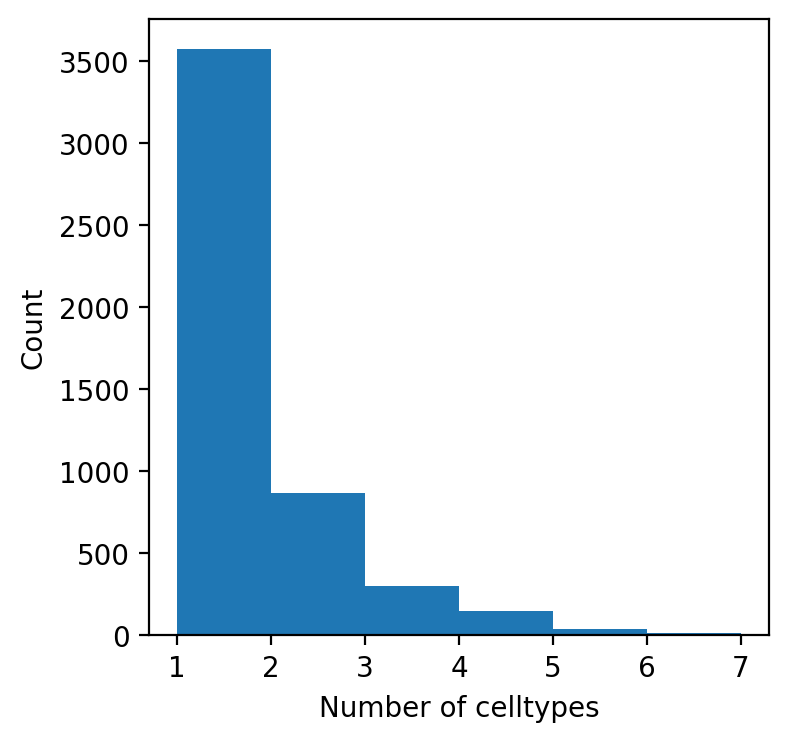

In [9]:
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(4,4))
plt.hist(linked_shap_all_brain[celltypes].sum(axis=1).values,bins=np.arange(1,8,1))
plt.ylabel("Count")
plt.xlabel("Number of celltypes")
print(f"Mean = {np.mean(linked_shap_all_brain[celltypes].sum(axis=1).values):.2f},meidan = {np.median(linked_shap_all_brain[celltypes].sum(axis=1).values)}")

In [10]:
np.mean(linked_shap_all_brain[celltypes].sum(axis=1).values)

1.4424707307226483

In [11]:
linked_shap_all_brain[celltypes].sum().sort_values()

Ex_L3/4_IT         100
Ex_L5/6_IT         172
Ex_L2/3_IT         183
Ex_L6_CT           200
Inh_MSN            230
Ex_OB              259
Microglia          472
Inh_Sst            486
Inh_Pvalb          497
ODC                497
OPC                499
Ex_L5/6_NP         505
Inh_Vip            566
Ast                581
Ex_CL              768
Inh_Ndnf/Lamp5    1131
dtype: int64

In [12]:
linked_shap_all_brain[celltypes].sum().sort_values().sum()

7146

/tmp/ipykernel_113946/2986987454.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pdata, x="celltype", y="num_eg_pairs", palette=celltype_colors)


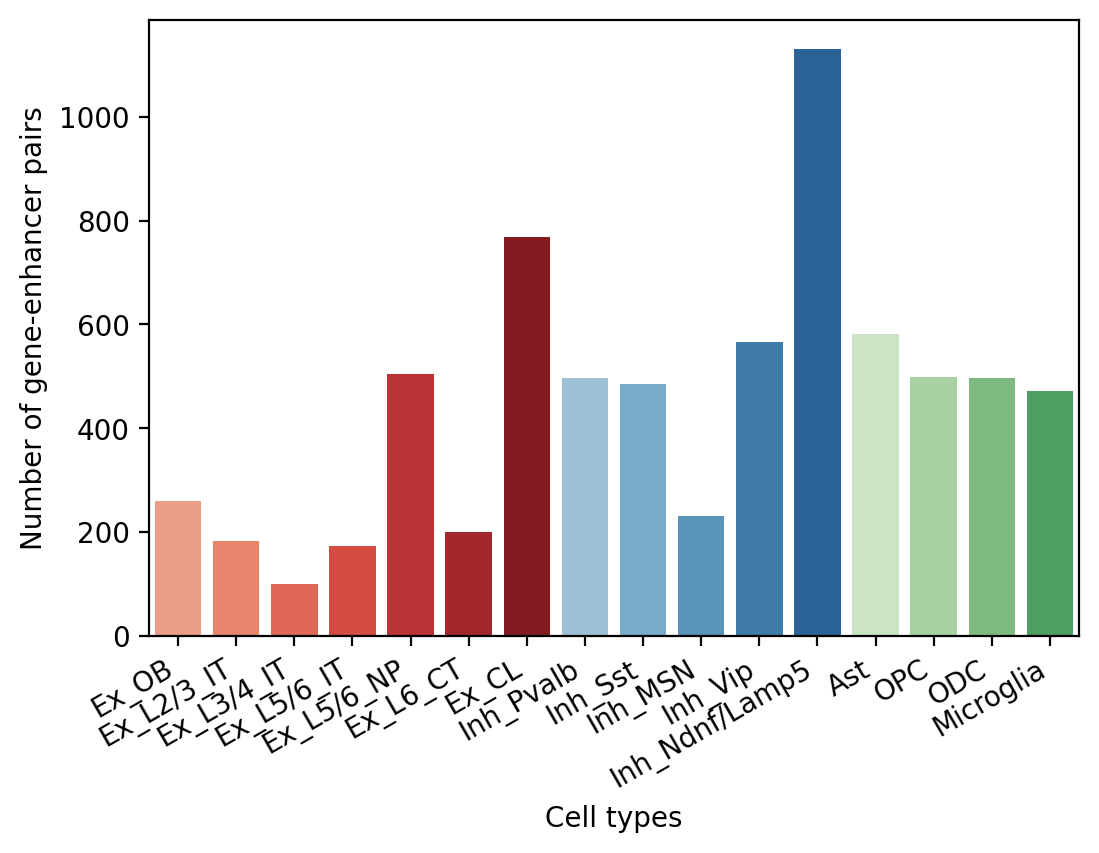

In [13]:
%config InlineBackend.figure_format = 'retina'

pdata = (linked_shap_all_brain.set_index(["chrom","pos","gene"])[celltypes]).sum(axis=0)
pdata =pdata.reset_index()
pdata.columns = ["celltype","num_eg_pairs"]


plt.figure(figsize=(6,4))
pdata["celltype"] = pd.Categorical(pdata["celltype"], categories=celltype_colors.keys(), ordered=True)
pdata = pdata.sort_values("celltype")
sns.barplot(data=pdata, x="celltype", y="num_eg_pairs", palette=celltype_colors)

plt.xticks(rotation=30, ha='right')
plt.xlabel("Cell types")
plt.ylabel("Number of gene-enhancer pairs")
#plt.yscale("log")

# save 
plt.savefig("figures/linkage_count_per_celltype_bar.pdf", bbox_inches='tight', dpi=300)
plt.show()


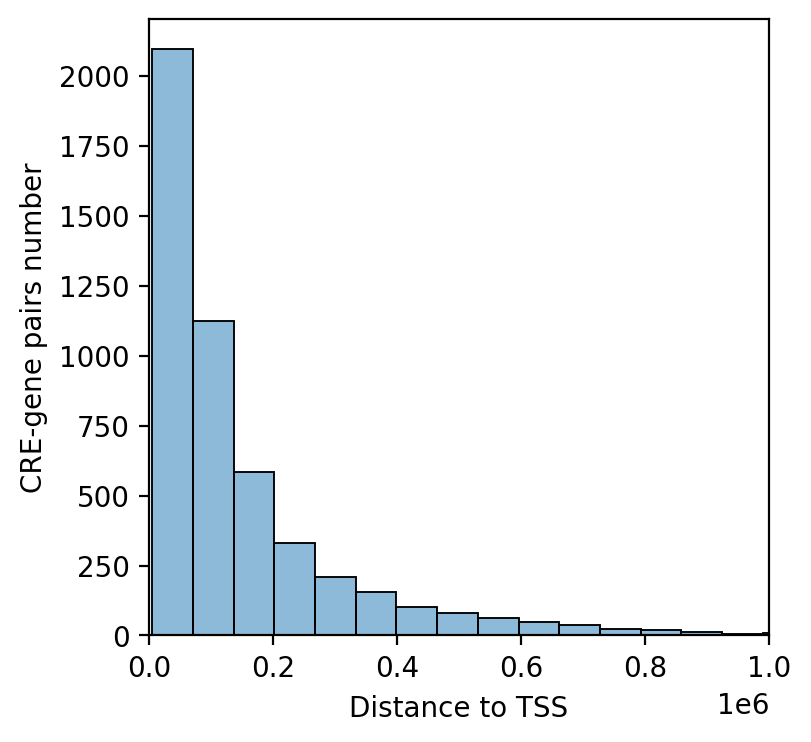

In [14]:
plt.figure(figsize=(4,4))

sns.histplot(data = linked_shap_all_brain, x="abs_distance_to_tss", 
             #hue="within_gene", 
             bins=30, 
             alpha=0.5)
plt.xlabel("Distance to TSS")
plt.ylabel("CRE-gene pairs number")
# remove grid
plt.grid(False)
plt.xlim(0,1e6)

plt.savefig("figures/linkage_distance_to_tss_hist.pdf", bbox_inches='tight', dpi=300)

In [15]:
linked_shap_all_brain.query('abs_distance_to_tss < 200000').shape[0] / linked_shap_all_brain.shape[0]

0.7612030682276948

In [16]:
linked_shap_all_brain_contact["max_shap"] = linked_shap_all_brain_contact[celltypes].max(axis=1)
linked_shap_all_brain_contact["abs_distance_to_tss_group"] = pd.cut(linked_shap_all_brain_contact["abs_distance_to_tss"],
                                                                    bins=[0, 2e5, 4e5, 6e5,1e6])

linked_shap_all_brain_atac["max_shap"] = linked_shap_all_brain_atac[celltypes].max(axis=1)
linked_shap_all_brain_atac["abs_distance_to_tss_group"] = pd.cut(linked_shap_all_brain_atac["abs_distance_to_tss"],
                                                                    bins=[0, 2e5, 4e5, 6e5,1e6])
linked_shap_all_brain_ct["max_shap"] = linked_shap_all_brain_ct[celltypes].max(axis=1)
linked_shap_all_brain_ct["abs_distance_to_tss_group"] = pd.cut(linked_shap_all_brain_ct["abs_distance_to_tss"],
                                                                    bins=[0, 2e5, 4e5, 6e5,1e6])

In [17]:
linked_shap_all_brain_contact.groupby("abs_distance_to_tss_group").size()

/tmp/ipykernel_113946/2980334731.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  linked_shap_all_brain_contact.groupby("abs_distance_to_tss_group").size()


abs_distance_to_tss_group
(0.0, 200000.0]          3807
(200000.0, 400000.0]      700
(400000.0, 600000.0]      241
(600000.0, 1000000.0]     145
dtype: int64

In [18]:
import numpy as np
from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the widths of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [19]:
# first Within Gene, then Intergenic
linked_shap_all_brain_contact["category"] = pd.Categorical(
    linked_shap_all_brain_contact["within_gene"].replace({True: "Within Gene", False: "Intergenic"}),
    categories=["Within Gene", "Intergenic"],
    ordered=True
)
linked_shap_all_brain_atac["category"] = pd.Categorical(
    linked_shap_all_brain_atac["within_gene"].replace({True: "Within Gene", False: "Intergenic"}),
    categories=["Within Gene", "Intergenic"],
    ordered=True
)
linked_shap_all_brain_ct["category"] = pd.Categorical(
    linked_shap_all_brain_ct["within_gene"].replace({True: "Within Gene", False: "Intergenic"}),
    categories=["Within Gene", "Intergenic"],
    ordered=True
)

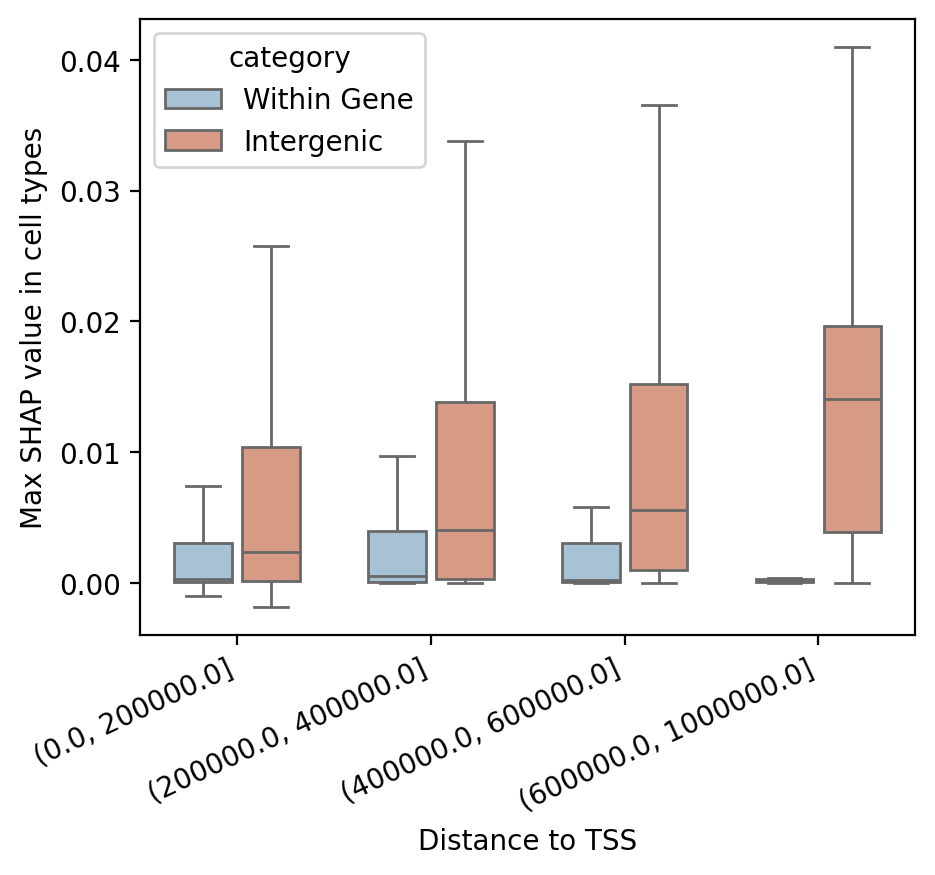

In [20]:
# boxplot of max_shap by abs_distance_to_tss_group
fig = plt.figure(figsize=(5,4))
sns.boxplot(data=linked_shap_all_brain_contact, 
            x="abs_distance_to_tss_group", 
            y="max_shap", 
            hue="category", 
            palette=["#a1c3dc","#e49477"], 
            width=0.7,
            showfliers=False)
plt.xticks(rotation=25, ha='right')
plt.xlabel("Distance to TSS")
plt.ylabel("Max SHAP value in cell types")
adjust_box_widths(fig, 0.85)
plt.savefig("figures/shap_by_distance_contact.pdf", bbox_inches='tight')

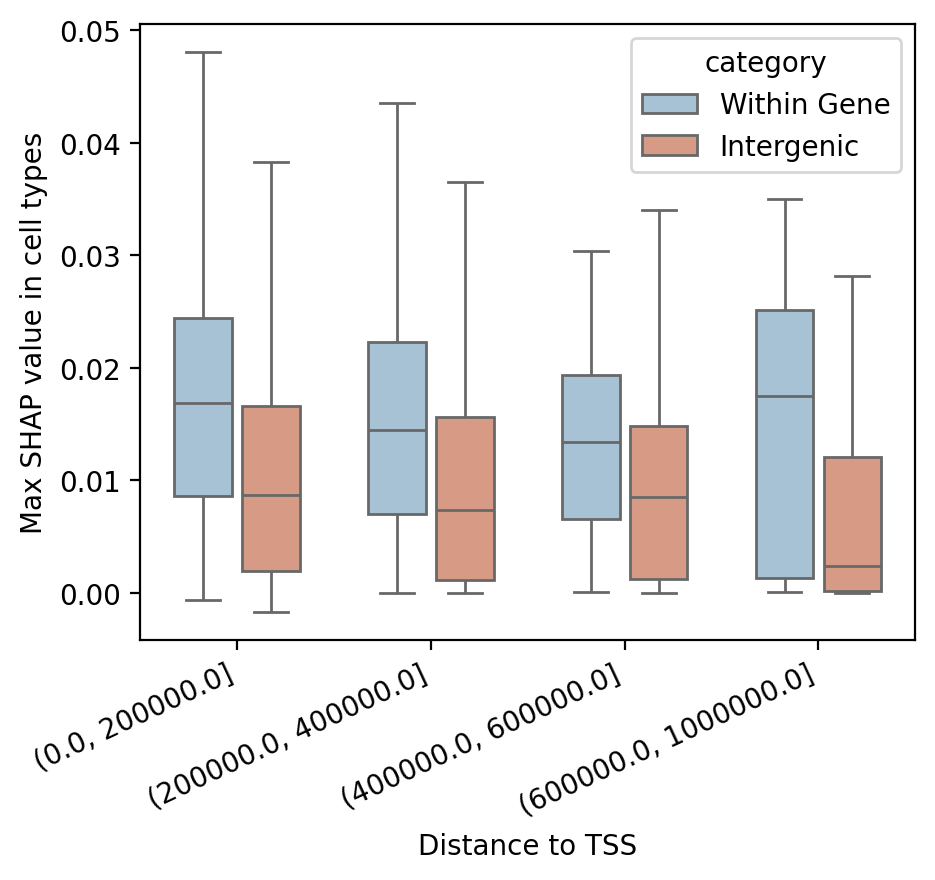

In [21]:
# boxplot of max_shap by abs_distance_to_tss_group
fig = plt.figure(figsize=(5,4))
sns.boxplot(data=linked_shap_all_brain_atac, 
            x="abs_distance_to_tss_group", 
            y="max_shap", 
            hue="category", 
            palette=["#a1c3dc","#e49477"], 
            width=0.7,
            showfliers=False)
plt.xticks(rotation=25, ha='right')
plt.xlabel("Distance to TSS")
plt.ylabel("Max SHAP value in cell types")
adjust_box_widths(fig, 0.85)
plt.savefig("figures/shap_by_distance_atac.pdf", bbox_inches='tight')

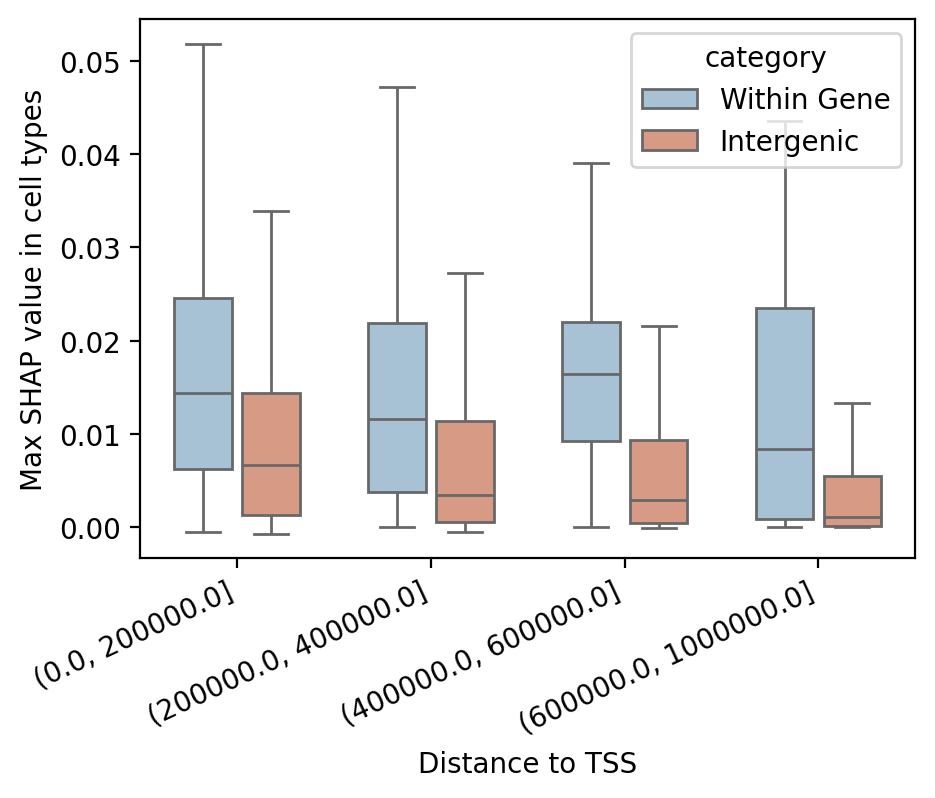

In [22]:
# boxplot of max_shap by abs_distance_to_tss_group
fig = plt.figure(figsize=(5,3.5))
sns.boxplot(data=linked_shap_all_brain_ct, 
            x="abs_distance_to_tss_group", 
            y="max_shap", 
            hue="category", 
            palette=["#a1c3dc","#e49477"], 
            width=0.7,
            showfliers=False)
plt.xticks(rotation=25, ha='right')
plt.xlabel("Distance to TSS")
plt.ylabel("Max SHAP value in cell types")
adjust_box_widths(fig, 0.85)
plt.savefig("figures/shap_by_distance_h3k27ac.pdf", bbox_inches='tight')

In [23]:
temp_df = linked_shap_all_brain.query('category == "Intergenic"')[["chrom","pos","distance_to_tss","gene"]]
temp_df["start"] = temp_df.apply(lambda x: min(x["pos"], x["pos"] - x["distance_to_tss"]), axis=1)
temp_df["end"] = temp_df.apply(lambda x: max(x["pos"], x["pos"] - x["distance_to_tss"]), axis=1)
temp_df = temp_df[["chrom","start","end","gene"]]
temp_df["start"] = temp_df["start"].astype(int)
temp_df["end"] = temp_df["end"].astype(int)

In [24]:
genes_all = pd.read_csv("/share/Data/public/ref_genome/mouse_ref/M23/raw_data/gene.bed",sep="\t",header=None)
genes_all.columns = ["chrom","start","end","id","gene","strand"]
genes_all["tss_start"] = genes_all.apply(lambda x: x["start"] if x["strand"] == "+" else x["end"], axis=1)
genes_all["tss_end"] = genes_all["tss_start"] + 1
tss_all = genes_all[["chrom","tss_start","tss_end","gene"]]
tss_all.columns = ["chrom","start","end","gene"]
#tss_all["count"] = 1
tss_all.loc[:,"count"]=1

/tmp/ipykernel_113946/4123329377.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tss_all.loc[:,"count"]=1


In [25]:
from pybedtools import BedTool
temp_bed = BedTool.from_dataframe(temp_df)
tss_bed = BedTool.from_dataframe(tss_all)
intersected = temp_bed.intersect(tss_bed, wa=True, wb=True,loj=True)
intersected_df = intersected.to_dataframe()
intersected_df.columns = ["chrom", "start", "end", "gene", "tss_chrom", "tss_start", "tss_end", "tss_gene", "count"]
# if count == -1 convert to 0
intersected_df["count"] = intersected_df["count"].replace(-1, 0)
# if tss_gene == gene , set count to 0
intersected_df.loc[intersected_df["tss_gene"] == intersected_df["gene"], "count"] = 0

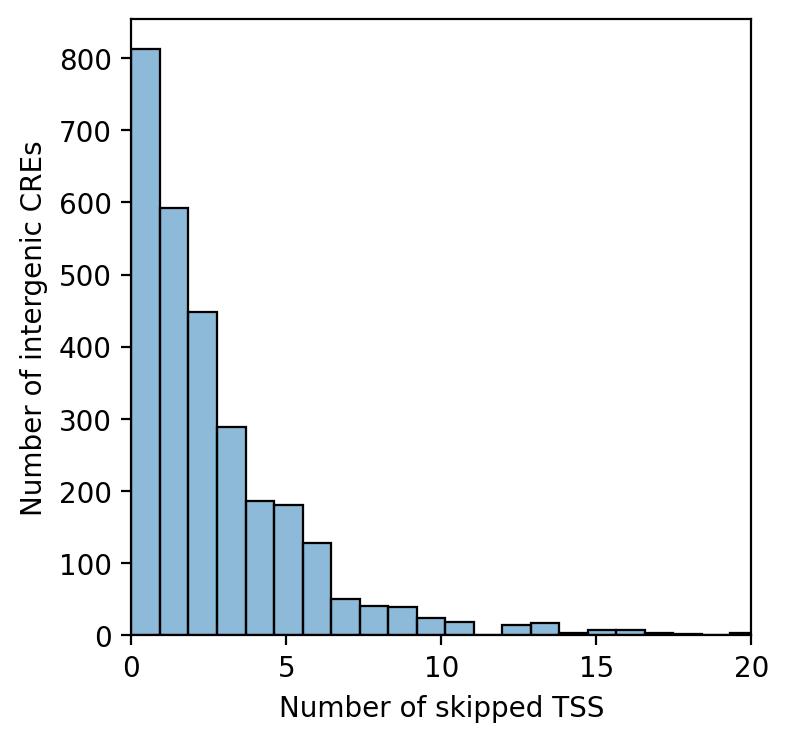

In [26]:
pdata = intersected_df.groupby(["chrom","start","end","gene"])["count"].sum().reset_index()
# histogram of count
# plt.figure(figsize=(4,4))
# plt.hist(pdata["count"], bins=np.arange(0, 25, 1))
# plt.xlabel("Number of skipped TSS")
# plt.ylabel("Number of intergenic CREs")
# plt.show()
plt.figure(figsize=(4,4))

sns.histplot(data=pdata, x="count",
             bins=25,
             alpha=0.5)
plt.xlabel("Number of skipped TSS")
plt.ylabel("Number of intergenic CREs")
plt.grid(False)
plt.xlim(0, 20)
# plt.show()
plt.savefig("figures/skipped_tss_hist.pdf", bbox_inches='tight', dpi=300)

## corr with expression

In [27]:
exp_celltype = pd.read_table("/zliu_ssd/CHARM/CHARM_brain/data/RNA/counts.gene.total.format.tsv.gz",sep="\t")
exp_celltype = exp_celltype.set_index("gene").T

In [28]:
exp_celltype = pd.DataFrame(exp_celltype).reset_index().rename(columns={"index": "cellname"}).\
    merge(metadata[["cellname","celltype"]]).set_index("cellname").groupby("celltype").mean().T

exp_celltype = pd.DataFrame(exp_celltype)

In [29]:
linked_shap_all_brain_summarised = linked_shap_all_brain.query('category == "Intergenic"').groupby("gene")[celltypes].sum().copy()
exp_celltype_temp = exp_celltype.loc[linked_shap_all_brain_summarised.index.values,celltypes].copy()

In [30]:
# for each gene, calc pearson correlation between linked_shap_all_brain_summarised and exp_celltype
pearson_corr_res = []
spearman_corr_res = []
for gene in exp_celltype_temp.index:
    shap_values = linked_shap_all_brain_summarised.loc[gene].values
    expression_values = exp_celltype_temp.loc[gene].values
    
    if np.any(np.isnan(shap_values)) or np.any(np.isnan(expression_values)):
        continue
    
    pearson_corr_res.append((gene, stats.pearsonr(shap_values, expression_values)[0]))
    spearman_corr_res.append((gene, stats.spearmanr(shap_values, expression_values)[0]))
    

# Create a DataFrame from the results
correlation_df_pearson = pd.DataFrame(pearson_corr_res, columns=['gene', 'pearson_correlation'])
correlation_df_spearman = pd.DataFrame(spearman_corr_res, columns=['gene', 'spearman_correlation'])

correlation_df_intergenic = correlation_df_pearson.merge(correlation_df_spearman, on="gene")


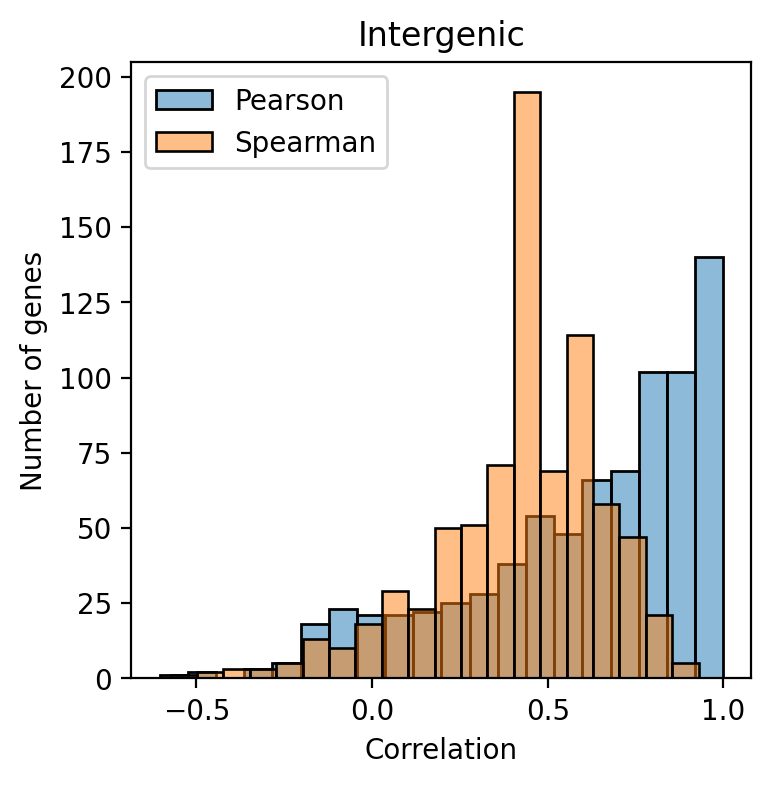

In [31]:
# hist of pearson and spearman coorr
plt.figure(figsize=(4, 4))
sns.histplot(correlation_df_intergenic["pearson_correlation"], bins=20, label='Pearson', alpha=0.5)
sns.histplot(correlation_df_intergenic["spearman_correlation"], bins=20, label='Spearman', alpha=0.5)
plt.xlabel("Correlation")
plt.ylabel("Number of genes")
plt.title("Intergenic")
plt.legend()



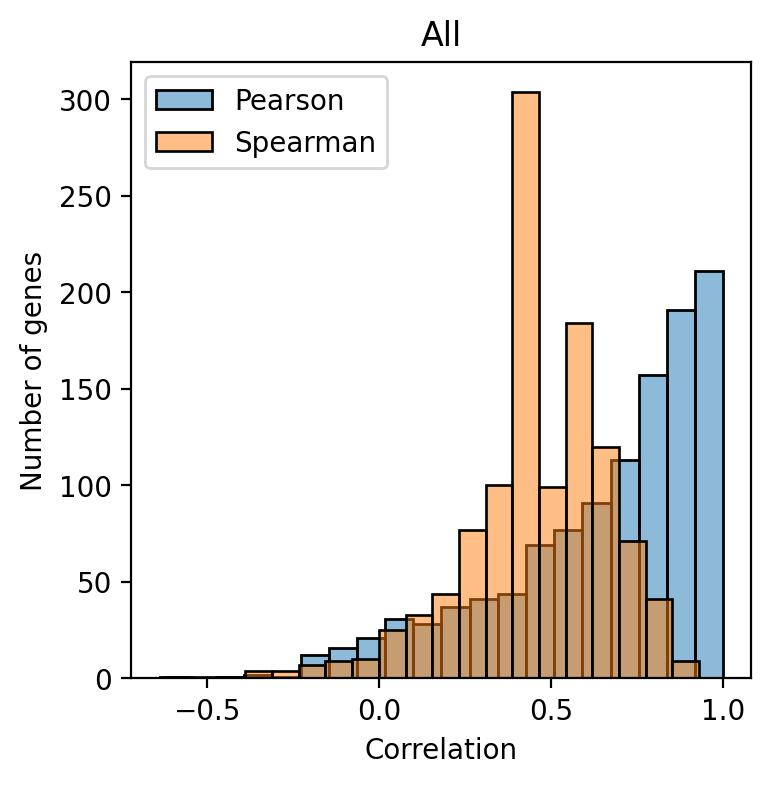

In [32]:
linked_shap_all_brain_summarised = linked_shap_all_brain.groupby("gene")[celltypes].sum().copy()
exp_celltype_temp = exp_celltype.loc[linked_shap_all_brain_summarised.index.values,celltypes].copy()

# for each gene, calc pearson correlation between linked_shap_all_brain_summarised and exp_celltype
pearson_corr_res = []
spearman_corr_res = []
for gene in exp_celltype_temp.index:
    shap_values = linked_shap_all_brain_summarised.loc[gene].values
    expression_values = exp_celltype_temp.loc[gene].values
    
    if np.any(np.isnan(shap_values)) or np.any(np.isnan(expression_values)):
        continue
    
    pearson_corr_res.append((gene, stats.pearsonr(shap_values, expression_values)[0]))
    spearman_corr_res.append((gene, stats.spearmanr(shap_values, expression_values)[0]))
    

# Create a DataFrame from the results
correlation_df_pearson = pd.DataFrame(pearson_corr_res, columns=['gene', 'pearson_correlation'])
correlation_df_spearman = pd.DataFrame(spearman_corr_res, columns=['gene', 'spearman_correlation'])

correlation_df = correlation_df_pearson.merge(correlation_df_spearman, on="gene")
# hist of pearson and spearman coorr
plt.figure(figsize=(4, 4))
sns.histplot(correlation_df["pearson_correlation"], bins=20, label='Pearson', alpha=0.5)
sns.histplot(correlation_df["spearman_correlation"], bins=20, label='Spearman', alpha=0.5)
plt.xlabel("Correlation")
plt.ylabel("Number of genes")
plt.title("All")
plt.legend()



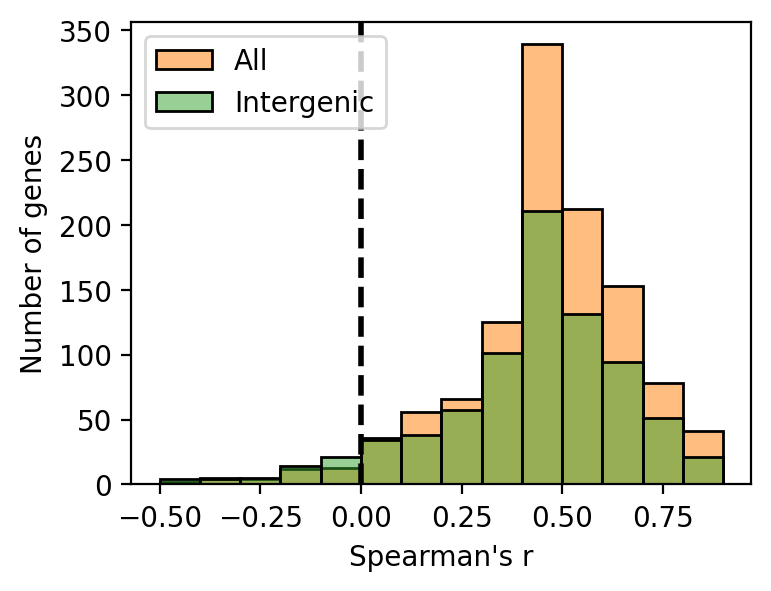

In [33]:
plt.figure(figsize=(4, 3))
sns.histplot(correlation_df["spearman_correlation"],bins=np.arange(-0.5,1,0.1), label='All', alpha=0.5,color="#ff7f00")
sns.histplot(correlation_df_intergenic["spearman_correlation"], bins=np.arange(-0.5,1,0.1), label='Intergenic', alpha=0.5,color="#33a02c")

# verticle at 0
plt.axvline(0, color='black', linestyle='--', linewidth=2)

plt.xlabel("Spearman's r")
plt.ylabel("Number of genes")
plt.legend(loc='upper left')

# save 
plt.savefig("figures/enhancer_num_corr.pdf", bbox_inches='tight')


## output igv track

In [34]:
towrite = linked_shap_all_brain[["chrom","pos","gene"]]
towrite["chrom"] = towrite["chrom"].astype(str)
towrite["start"] = towrite["pos"].astype(int)
towrite["end"] = (towrite["pos"] + 5000).astype(int)

towrite = towrite[["chrom","start","end","gene"]]
towrite.to_csv("enhancer_gene_pairs.bed", sep="\t", index=False, header=False)


/tmp/ipykernel_113946/4252373934.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  towrite["chrom"] = towrite["chrom"].astype(str)
/tmp/ipykernel_113946/4252373934.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  towrite["start"] = towrite["pos"].astype(int)
/tmp/ipykernel_113946/4252373934.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

## Output table

In [36]:
linked_shap_all_brain.to_csv("CHARM_linkages.tsv", sep="\t", index=False)